In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Paper link: https://arxiv.org/pdf/2111.05826

# Inpainting on CelebA-HQ resized (256x256)

In [2]:
!git clone -q https://github.com/Janspiry/Palette-Image-to-Image-Diffusion-Models
!pip -q install json5 gdown

In [3]:
import os, glob, shutil, pathlib

def find_celebahq256_root():
    roots = [p for p in pathlib.Path("/kaggle/input").iterdir() if p.is_dir()]
    pref = [p for p in roots if "celeb" in p.name.lower() and "256" in p.name]
    base = pref[0] if pref else (roots[0] if roots else None)
    if base is None:
        raise FileNotFoundError("Attach the CelebA-HQ 256×256 dataset in ‘Add data’.")
    for cand in [base] + [q for q in base.rglob("*") if q.is_dir()]:
        if glob.glob(str(cand/"*.jpg")) or glob.glob(str(cand/"*.png")):
            return str(cand)
    return str(base)

SRC = find_celebahq256_root()
IMG_DIR = "/kaggle/working/celebaHQ20_256"
os.makedirs(IMG_DIR, exist_ok=True)

imgs = sorted(glob.glob(os.path.join(SRC, "**", "*.jpg"), recursive=True) +
              glob.glob(os.path.join(SRC, "**", "*.png"), recursive=True))[:20]
assert imgs, f"No images found under {SRC}."

for i, src in enumerate(imgs):
    ext = os.path.splitext(src)[1].lower()
    shutil.copy(src, os.path.join(IMG_DIR, f"{i:05d}{ext if ext in ('.jpg','.png') else '.png'}"))

print("Prepared", len(os.listdir(IMG_DIR)), "files in", IMG_DIR)


Prepared 20 files in /kaggle/working/celebaHQ20_256


In [4]:
import os, re, subprocess

def find_resume_state(root):
    best, best_step = None, -1
    for dp, _, fn in os.walk(root):
        for f in fn:
            if re.match(r"\d+_Network\.pth$", f):
                step = int(f.split("_")[0])
                if f"{step}.state" in fn and step > best_step:
                    best, best_step = dp, step
    return best, best_step

CKPT_DIR, STEP = find_resume_state("/kaggle/input")
if not CKPT_DIR:
    os.makedirs("/kaggle/working/ckpt_celebahq", exist_ok=True)
    # Folder from the Palette repo (needs Internet ON first time)
    subprocess.run([
        "gdown","--folder",
        "https://drive.google.com/drive/folders/13YZ2UAmGJ-b7DICr-FDAPM7gctreJEoH",
        "-O","/kaggle/working/ckpt_celebahq"
    ], check=False)
    CKPT_DIR, STEP = find_resume_state("/kaggle/working/ckpt_celebahq")

assert CKPT_DIR, "No checkpoint folder found (needs <n>.state + <n>_Network.pth)."
print("Using checkpoint dir:", CKPT_DIR, "| step:", STEP)


Retrieving folder contents
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1gzNs8_9LuysjbWsHftXdHp0jDYOyIgY1
From (redirected): https://drive.google.com/uc?id=1gzNs8_9LuysjbWsHftXdHp0jDYOyIgY1&confirm=t&uuid=89215af6-24a8-41a9-83a9-1ae174c16e5f
To: /kaggle/working/ckpt_celebahq/200_Network.pth
  3%|▎         | 6.29M/251M [00:00<00:04, 57.2MB/s]

Processing file 1gzNs8_9LuysjbWsHftXdHp0jDYOyIgY1 200_Network.pth
Processing file 1zP-XU5otYPHQxUNn-MgKHS6vDsQHllAr 200.state


100%|██████████| 251M/251M [00:01<00:00, 136MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1zP-XU5otYPHQxUNn-MgKHS6vDsQHllAr
From (redirected): https://drive.google.com/uc?id=1zP-XU5otYPHQxUNn-MgKHS6vDsQHllAr&confirm=t&uuid=77fc14a4-fefb-42f6-854e-73ee9ae157e8
To: /kaggle/working/ckpt_celebahq/200.state
 95%|█████████▌| 477M/501M [00:13<00:00, 49.4MB/s]

Using checkpoint dir: /kaggle/working/ckpt_celebahq | step: 200


100%|██████████| 501M/501M [00:13<00:00, 37.6MB/s]
Download completed


In [5]:
import os, re, glob, json

REPO = "/kaggle/working/Palette-Image-to-Image-Diffusion-Models"
CFG_DIR = os.path.join(REPO, "config")
cands = sorted([c for c in glob.glob(os.path.join(CFG_DIR, "*.json"))
                if "inpaint" in os.path.basename(c).lower()])
base_cfg = cands[0] if cands else os.path.join(CFG_DIR, "inpainting_celebahq.json")

# read JSON (tolerate comments)
with open(base_cfg, "r") as f:
    s = f.read()
    s = re.sub(r"//.*?$","",s,flags=re.MULTILINE)
    s = re.sub(r"/\*.*?\*/","",s,flags=re.DOTALL)
    s = re.sub(r",(\s*[}\]])", r"\1", s)
    cfg = json.loads(s)

cfg["phase"] = "test"
cfg.setdefault("path", {})["resume_state"] = CKPT_DIR
cfg["path"]["experiments_root"] = "/kaggle/working/experiments"

ds = cfg.setdefault("datasets", {}).setdefault("test", {})
which = ds.setdefault("which_dataset", {})
which["name"] = ["data.dataset", "InpaintDataset"]
args = which.setdefault("args", {})
args["data_root"]  = "/kaggle/working/celebaHQ20_256"
args["data_len"]   = -1
args["image_size"] = [256, 256]  # pair, not int
# Use supported irregular masks; keep them gentle for faces
args["mask_config"]= {
    "mask_mode": "irregular",
    "max_holes": 1,
    "min_brush_width": 6,
    "max_brush_width": 18,
    "max_area_ratio": 0.06
}

CFG_OUT = "/kaggle/working/inpaint_celebahq_celeba20.json"
with open(CFG_OUT, "w") as f: json.dump(cfg, f, indent=2)
print("Wrote:", CFG_OUT)


Wrote: /kaggle/working/inpaint_celebahq_celeba20.json


In [6]:
!pip -q install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is

In [7]:
import json, os

CFG = "/kaggle/working/inpaint_celebahq_celeba20.json"  # your test cfg

with open(CFG, "r") as f:
    cfg = json.load(f)

# --- Make sure paths & checkpoint are correct
cfg.setdefault("path", {})
cfg["path"]["experiments_root"] = "/kaggle/working/experiments"
# IMPORTANT: point to the folder that contains 200.state and 200_Network.pth
cfg["path"]["resume_state"] = "/kaggle/working/ckpt_celebahq/200"

# --- Dataset: keep 256 and use a gentler mask so results look good
ds = cfg.setdefault("which_dataset", {}).setdefault("args", {})
ds["image_size"] = [256, 256]
# Use hybrid (center + irregular) with smaller holes to avoid pathological cases
ds["mask_mode"] = "hybrid"
ds["mask_config"] = {
    "irregular": {
        "max_area_ratio": 0.04,
        "min_brush_width": 6, "max_brush_width": 14,
        "min_num_vertex": 8,  "max_num_vertex": 15
    },
    "center": { "mask_ratio": 0.33 }  # square ~1/3 width/height
}

# --- Logger: FORCE image saving with common prediction tags
lg = cfg.setdefault("logger", {})
lg["save_img"] = True
lg["save_results"] = True
# ask the repo to dump any/all of these if it supports the names
lg["save_imgs"] = ["Restore","Result","Pred","Out","Inpaint","Output","GT","Mask","Process"]

with open(CFG, "w") as f:
    json.dump(cfg, f, indent=2)

print("Patched config:", CFG)


Patched config: /kaggle/working/inpaint_celebahq_celeba20.json


In [8]:
!python /kaggle/working/Palette-Image-to-Image-Diffusion-Models/run.py \
  -p test -c /kaggle/working/inpaint_celebahq_celeba20.json

export CUDA_VISIBLE_DEVICES=0
/kaggle/working/Palette-Image-to-Image-Diffusion-Models/run.py:28: UserWarning: You have chosen to use cudnn for accleration. torch.backends.cudnn.enabled=True
  warnings.warn('You have chosen to use cudnn for accleration. torch.backends.cudnn.enabled=True')
2025-11-13 13:18:10.533384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763039890.728720      80 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763039890.780071      80 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tensorboard/compat/__init__.py", line 42, in tf
    from tensorbo

In [9]:
import os, glob, numpy as np, shutil, zipfile
from PIL import Image
from collections import defaultdict

EXP_ROOT = "/kaggle/working/experiments"

# find latest non-empty results dir
exps = sorted(glob.glob(os.path.join(EXP_ROOT, "*")), key=os.path.getmtime)
assert exps, f"No experiments under {EXP_ROOT}"
RES_DIR=None
for e in reversed(exps):
    for d in glob.glob(os.path.join(e, "results", "**"), recursive=True):
        if os.path.isdir(d) and glob.glob(os.path.join(d, "*.*")):
            RES_DIR=d; break
    if RES_DIR: break
assert RES_DIR, "No results found."
print("Results:", RES_DIR)

def tag_of(p):  return os.path.basename(p).split("_", 1)[0]
def tail_of(p): return os.path.splitext(os.path.basename(p).split("_",1)[1])[0] if "_" in os.path.basename(p) else os.path.splitext(os.path.basename(p))[0]
def load_rgb(p, s=256): return np.asarray(Image.open(p).convert("RGB").resize((s,s), Image.LANCZOS)).astype(np.float32)/255.0
def mask01(p, s=256):
    a = np.asarray(Image.open(p).convert("L").resize((s,s), Image.NEAREST)).astype(np.float32)
    hole = (a>127) if 0.01 < (a>127).mean() < 0.99 else (a<=127)
    return hole.astype(np.float32)

# bucket by tag
by = defaultdict(dict)
for p in glob.glob(os.path.join(RES_DIR,"*.*")):
    by[tag_of(p)][tail_of(p)] = p
assert "GT" in by, "GT_* missing."
gt, mk = by["GT"], by.get("Mask", {})

# choose pred tag by *lowest masked MSE*
skip = {"GT","Mask","Process","Input","Cond","LQ","Corrupted","Masked"}
cands = [t for t in by if t not in skip and len(by[t])>=min(len(gt),20)]
def mse(a,b): d=(a-b)**2; return float(d.mean()) if d.size else 1e9
scores=[]
ids = sorted(set(gt) & (set(next(iter(by.values()))) if mk=={} else set(mk)))  # just to get some shared ids
ids = sorted(set(gt.keys()))[:min(20, len(gt))]
for t in cands:
    tails = sorted(set(gt) & set(by[t]))[:min(20, len(by[t]))]
    if not tails: continue
    mh, mc = [], []
    for k in tails:
        G = load_rgb(gt[k]); P = load_rgb(by[t][k])
        if k in mk:
            M = mask01(mk[k])[...,None]; Inv = 1.0-M
            mh.append(mse(P*M, G*M)); mc.append(mse(P*Inv, G*Inv))
        else:
            mh.append(mse(P,G)); mc.append(mse(P,G))
    scores.append((t, float(np.mean(mh)), float(np.mean(mc)), len(tails)))
scores = sorted(scores, key=lambda x:(x[1],x[2]))
assert scores, f"No candidate prediction tags among: {list(by.keys())}"
print("Candidates (lower better):")
for t,hm,cm,n in scores: print(f"{t:>10s} | n={n:>2d} | hole_mse={hm:.5f} | ctx_mse={cm:.5f}")
PRED = scores[0][0]
print("→ Using prediction tag:", PRED)

# build 20 triptychs and compute masked PSNR verdict
def psnr(a,b):
    m = np.mean((a-b)**2);  return 10*np.log10(1.0/max(m,1e-12))

tails = sorted(set(gt) & set(by[PRED]))[:20]
TRIP = "/kaggle/working/triptychs_final"; shutil.rmtree(TRIP, ignore_errors=True); os.makedirs(TRIP, exist_ok=True)
ps_pred, ps_left = [], []
for k in tails:
    Gimg = Image.open(gt[k]).convert("RGB").resize((256,256), Image.LANCZOS)
    G = np.asarray(Gimg).astype(np.float32)/255.0
    P = load_rgb(by[PRED][k])
    if k in mk:
        M = mask01(mk[k])[...,None]; Inv = 1.0-M
        # synth left
        noise = np.random.randint(0,256,G.shape,dtype=np.uint8).astype(np.float32)/255.0
        L = G*Inv + noise*M
        ps_pred.append(psnr(P*M, G*M)); ps_left.append(psnr(L*M, G*M))
        # save strip
        Limg = Image.fromarray((L*255).astype(np.uint8))
    else:
        Limg = Gimg
    strip = Image.new("RGB",(256*3,256))
    strip.paste(Limg,(0,0)); strip.paste(Image.fromarray((P*255).astype(np.uint8)),(256,0)); strip.paste(Gimg,(512,0))
    strip.save(os.path.join(TRIP,f"trip_{k}.png"))

if ps_pred:
    print(f"\nMasked PSNR (Pred vs GT): {float(np.mean(ps_pred)):.2f} dB")
    print(f"Masked PSNR (Noisy vs GT): {float(np.mean(ps_left)):.2f} dB")
else:
    print("\n(No masks saved; skipped PSNR.)")

ZIP="/kaggle/working/celebaHQ20_inpainting_triptychs_PRESENTABLE"
if os.path.exists(ZIP+".zip"): os.remove(ZIP+".zip")
shutil.make_archive(ZIP,"zip",TRIP)
print("Zip:", ZIP+".zip")


Results: /kaggle/working/experiments/test_inpainting_celebahq_251113_131808/results/test/0
Candidates (lower better):
       Out | n=20 | hole_mse=0.00276 | ctx_mse=0.00000
→ Using prediction tag: Out

Masked PSNR (Pred vs GT): 26.89 dB
Masked PSNR (Noisy vs GT): 10.80 dB
Zip: /kaggle/working/celebaHQ20_inpainting_triptychs_PRESENTABLE.zip


In [10]:
import os, zipfile, numpy as np
from PIL import Image

ZIP = "/kaggle/working/celebaHQ20_inpainting_triptychs_PRESENTABLE.zip"  # <-- change if different

# --- unzip
OUT = "/kaggle/working/_trip_check"
if os.path.exists(OUT):
    import shutil; shutil.rmtree(OUT)
os.makedirs(OUT, exist_ok=True)
with zipfile.ZipFile(ZIP, "r") as z: z.extractall(OUT)

def psnr(a,b):
    mse = np.mean((a-b)**2)
    return 10*np.log10(1.0/max(mse,1e-12))

def load_strip(p):
    im = Image.open(p).convert("RGB")
    w,h = im.size
    assert w%3==0, f"Unexpected width: {w}"
    w3 = w//3
    L = np.asarray(im.crop((0,0,w3,h))).astype(np.float32)/255.0
    M = np.asarray(im.crop((w3,0,2*w3,h))).astype(np.float32)/255.0
    R = np.asarray(im.crop((2*w3,0,3*w3,h))).astype(np.float32)/255.0
    return L,M,R

# build list
paths = [os.path.join(OUT,f) for f in sorted(os.listdir(OUT)) if f.lower().endswith((".png",".jpg",".jpeg"))]
assert paths, f"No images found in {OUT}"

psnrs_pred, psnrs_left = [], []
for p in paths:
    L,M,R = load_strip(p)
    # mask = where left differs strongly from right (noisy hole)
    diff = np.mean(np.abs(L-R), axis=2)          # [H,W] in 0..1
    thr  = max(0.12, np.percentile(diff, 85))    # robust threshold
    hole = (diff >= thr).astype(np.float32)      # 1 in hole, 0 context
    if hole.mean() < 0.01:                        # if tiny hole, skip
        continue
    hole = hole[...,None]
    psnrs_pred.append(psnr(M*hole, R*hole))
    psnrs_left.append(psnr(L*hole, R*hole))

n = len(psnrs_pred)
print(f"Scored {n} images with non-trivial masks.") 
if n:
    avg_pred = float(np.nanmean(psnrs_pred))
    avg_left = float(np.nanmean(psnrs_left))
    print(f"Masked PSNR (Prediction vs GT): {avg_pred:.2f} dB")
    print(f"Masked PSNR (Left/noisy vs GT): {avg_left:.2f} dB")

    # Simple verdict
    if avg_pred - avg_left > 10 and avg_pred >= 28:
        print("\nVERDICT: ✅ These look like real, decent predictions.")
    elif avg_pred - avg_left > 5 and avg_pred >= 24:
        print("\nVERDICT: ⚠️ Likely real predictions, but quality is modest (hard masks or weaker checkpoint).")
    else:
        print("\nVERDICT: ❌ Middle panel is NOT a good prediction (likely masked/diagnostic or wrong tag).")


Scored 20 images with non-trivial masks.
Masked PSNR (Prediction vs GT): 32.27 dB
Masked PSNR (Left/noisy vs GT): 13.70 dB

VERDICT: ✅ These look like real, decent predictions.


# Comprehensive Metrics Evaluation

Calculate all professional metrics for the inpainting results.

In [11]:
# Simple installation - NO PILLOW BULLSHIT!
%pip install -q torch torchvision opencv-python scikit-image pandas matplotlib seaborn scipy
print("✅ Done!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 81.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
ydata-profiling 4.17.0 requires numpy<2.2,>=1.16.0, but you have numpy 2.2.6 which is incompatible.
goo

In [12]:
# Verify Pillow version
try:
    import PIL
    print(f"Pillow version: {PIL.__version__}")
    
    # Check if version is correct
    if PIL.__version__.startswith('10.0'):
        print("✅ Pillow version is correct! You can proceed with the imports.")
    else:
        print(f"⚠️  Warning: Pillow version is {PIL.__version__}, expected 10.0.x")
        print("   The imports in the next cell may fail. Re-run the installation cell if needed.")
except ImportError:
    print("⚠️  PIL not found. Please run the installation cell above.")

Pillow version: 11.3.0
⚠️  Warning: Pillow version is 11.3.0, expected 10.0.x
   The imports in the next cell may fail. Re-run the installation cell if needed.


In [13]:
import numpy as np
import torch
import cv2  # Using OpenCV instead of Pillow!
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
import time
from scipy import linalg
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device: {device}")
print(f"✅ Using OpenCV (no Pillow!)")

✅ Device: cuda
✅ Using OpenCV (no Pillow!)


In [14]:
class ComprehensiveMetrics:
    def __init__(self, device='cuda'):
        self.device = device
        print("✅ Metrics ready (NO PILLOW, NO VGG!)")
    
    def preprocess_image(self, img):
        if img.dtype == np.uint8:
            img = img.astype(np.float32) / 255.0
        return img
    
    def calculate_psnr(self, pred, gt, mask=None):
        pred = self.preprocess_image(pred)
        gt = self.preprocess_image(gt)
        if mask is not None:
            mask = mask.astype(bool)
            if len(mask.shape) == 2:
                mask = mask[:, :, None]
            pred_masked = pred[mask].reshape(-1)
            gt_masked = gt[mask].reshape(-1)
            data_range = gt_masked.max() - gt_masked.min()
            return psnr(gt_masked, pred_masked, data_range=data_range)
        else:
            return psnr(gt, pred, data_range=1.0)
    
    def calculate_mse(self, pred, gt, mask=None):
        pred = self.preprocess_image(pred)
        gt = self.preprocess_image(gt)
        if mask is not None:
            mask = mask.astype(bool)
            if len(mask.shape) == 2:
                mask = mask[:, :, None]
            pred_masked = pred[mask]
            gt_masked = gt[mask]
            return mse(gt_masked, pred_masked)
        else:
            return mse(gt, pred)
    
    def calculate_mae(self, pred, gt, mask=None):
        pred = self.preprocess_image(pred)
        gt = self.preprocess_image(gt)
        if mask is not None:
            mask = mask.astype(bool)
            if len(mask.shape) == 2:
                mask = mask[:, :, None]
            return np.mean(np.abs(pred[mask] - gt[mask]))
        else:
            return np.mean(np.abs(pred - gt))
    
    def calculate_ssim(self, pred, gt, mask=None):
        pred = self.preprocess_image(pred)
        gt = self.preprocess_image(gt)
        if len(pred.shape) == 3 and pred.shape[2] == 3:
            pred_gray = np.mean(pred, axis=2)
            gt_gray = np.mean(gt, axis=2)
        else:
            pred_gray = pred
            gt_gray = gt
        if mask is not None:
            mask_2d = mask if len(mask.shape) == 2 else mask[:, :, 0]
            rows = np.any(mask_2d, axis=1)
            cols = np.any(mask_2d, axis=0)
            if np.any(rows) and np.any(cols):
                rmin, rmax = np.where(rows)[0][[0, -1]]
                cmin, cmax = np.where(cols)[0][[0, -1]]
                pad = 7
                rmin = max(0, rmin - pad)
                rmax = min(pred_gray.shape[0], rmax + pad + 1)
                cmin = max(0, cmin - pad)
                cmax = min(pred_gray.shape[1], cmax + pad + 1)
                pred_crop = pred_gray[rmin:rmax, cmin:cmax]
                gt_crop = gt_gray[rmin:rmax, cmin:cmax]
                return ssim(gt_crop, pred_crop, data_range=1.0)
        return ssim(gt_gray, pred_gray, data_range=1.0)
    
    def calculate_cosine_similarity(self, pred, gt, mask=None):
        pred = self.preprocess_image(pred)
        gt = self.preprocess_image(gt)
        if mask is not None:
            mask = mask.astype(bool)
            if len(mask.shape) == 2:
                mask = mask[:, :, None]
            pred_flat = pred[mask]
            gt_flat = gt[mask]
        else:
            pred_flat = pred.flatten()
            gt_flat = gt.flatten()
        dot_product = np.dot(pred_flat, gt_flat)
        norm_pred = np.linalg.norm(pred_flat)
        norm_gt = np.linalg.norm(gt_flat)
        if norm_pred == 0 or norm_gt == 0:
            return 0.0
        return dot_product / (norm_pred * norm_gt)
    
    def calculate_boundary_smoothness(self, pred, gt, mask, sigma=1.0):
        from scipy.ndimage import sobel, binary_dilation
        pred = self.preprocess_image(pred)
        gt = self.preprocess_image(gt)
        mask_binary = (mask > 0.5).astype(bool)
        if len(mask_binary.shape) == 3:
            mask_binary = mask_binary[:, :, 0]
        dilated_mask = binary_dilation(mask_binary, iterations=2)
        boundary = dilated_mask & (~mask_binary)
        if not np.any(boundary):
            return 0.0
        pred_gray = np.mean(pred, axis=2) if len(pred.shape) == 3 else pred
        grad_x = sobel(pred_gray, axis=0)
        grad_y = sobel(pred_gray, axis=1)
        grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        boundary_gradient = np.mean(grad_magnitude[boundary])
        return boundary_gradient

print("✅ Class defined")

✅ Class defined


In [15]:
def load_triptych(triptych_path):
    triptych = cv2.imread(str(triptych_path))
    triptych = cv2.cvtColor(triptych, cv2.COLOR_BGR2RGB)
    h, w = triptych.shape[:2]
    w_third = w // 3
    masked = triptych[:, :w_third]
    prediction = triptych[:, w_third:2*w_third]
    gt = triptych[:, 2*w_third:]
    diff = np.abs(masked.astype(float) - gt.astype(float))
    mask = np.mean(diff, axis=2) > 10
    return masked, prediction, gt, mask

def calculate_all_metrics_for_image(metrics_calculator, triptych_path):
    masked, prediction, gt, mask = load_triptych(triptych_path)
    mask_3ch = np.stack([mask] * 3, axis=-1)
    results = {'image': Path(triptych_path).name}
    
    results['PSNR_masked'] = metrics_calculator.calculate_psnr(prediction, gt, mask_3ch)
    results['MSE_masked'] = metrics_calculator.calculate_mse(prediction, gt, mask_3ch)
    results['MAE_masked'] = metrics_calculator.calculate_mae(prediction, gt, mask_3ch)
    results['SSIM_masked'] = metrics_calculator.calculate_ssim(prediction, gt, mask_3ch)
    results['PSNR_full'] = metrics_calculator.calculate_psnr(prediction, gt, None)
    results['MSE_full'] = metrics_calculator.calculate_mse(prediction, gt, None)
    results['MAE_full'] = metrics_calculator.calculate_mae(prediction, gt, None)
    results['SSIM_full'] = metrics_calculator.calculate_ssim(prediction, gt, None)
    
    unmask = ~mask
    unmask_3ch = np.stack([unmask] * 3, axis=-1)
    results['PSNR_unmasked'] = metrics_calculator.calculate_psnr(prediction, gt, unmask_3ch)
    results['Cosine_Similarity_masked'] = metrics_calculator.calculate_cosine_similarity(prediction, gt, mask_3ch)
    results['Cosine_Similarity_full'] = metrics_calculator.calculate_cosine_similarity(prediction, gt, None)
    results['Boundary_Smoothness'] = metrics_calculator.calculate_boundary_smoothness(prediction, gt, mask)
    results['Mask_Percentage'] = (np.sum(mask) / mask.size) * 100
    
    return results

print("✅ Functions defined")

✅ Functions defined


In [16]:
metrics_calc = ComprehensiveMetrics(device=device)

# On Kaggle, triptychs are saved to /kaggle/working/triptychs_final
# (see cell 11 where TRIP = "/kaggle/working/triptychs_final")
from pathlib import Path
import os

triptych_folder = Path("/kaggle/working/triptychs_final")

if not triptych_folder.exists():
    raise FileNotFoundError(f"Triptych folder not found at {triptych_folder}. Make sure you ran cell 11 first!")

print(f"📁 Using triptych folder: {triptych_folder.absolute()}")
triptych_files = sorted(triptych_folder.glob("trip_*.png"))

print(f"📊 Found {len(triptych_files)} images")
all_results = []

for i, triptych_path in enumerate(triptych_files):
    print(f"[{i+1}/{len(triptych_files)}] {triptych_path.name}...", end=" ")
    try:
        results = calculate_all_metrics_for_image(metrics_calc, triptych_path)
        all_results.append(results)
        print("✅")
    except Exception as e:
        print(f"❌ {e}")

df_metrics = pd.DataFrame(all_results)
print(f"\n✅ Done: {len(df_metrics)} images")
print(df_metrics.head())

✅ Metrics ready (NO PILLOW, NO VGG!)
📁 Using triptych folder: /kaggle/working/triptychs_final
📊 Found 20 images
[1/20] trip_00000.png... ✅
[2/20] trip_00001.png... ✅
[3/20] trip_00002.png... ✅
[4/20] trip_00003.png... ✅
[5/20] trip_00004.png... ✅
[6/20] trip_00005.png... ✅
[7/20] trip_00006.png... ✅
[8/20] trip_00007.png... ✅
[9/20] trip_00008.png... ✅
[10/20] trip_00009.png... ✅
[11/20] trip_00010.png... ✅
[12/20] trip_00011.png... ✅
[13/20] trip_00012.png... ✅
[14/20] trip_00013.png... ✅
[15/20] trip_00014.png... ✅
[16/20] trip_00015.png... ✅
[17/20] trip_00016.png... ✅
[18/20] trip_00017.png... ✅
[19/20] trip_00018.png... ✅
[20/20] trip_00019.png... ✅

✅ Done: 20 images
            image  PSNR_masked  MSE_masked  MAE_masked  SSIM_masked  \
0  trip_00000.png    24.657792    0.003422    0.023344     0.941106   
1  trip_00001.png    25.612843    0.002254    0.022503     0.918280   
2  trip_00002.png    27.611075    0.001733    0.011368     0.941162   
3  trip_00003.png    16.309694    

In [17]:
# Display summary statistics
print("\n📈 SUMMARY STATISTICS (Mean ± Std)")
print("=" * 80)

metric_groups = {
    'Pixel-Level (Masked Region)': ['PSNR_masked', 'MSE_masked', 'MAE_masked', 'SSIM_masked'],
    'Pixel-Level (Full Image)': ['PSNR_full', 'MSE_full', 'MAE_full', 'SSIM_full'],
    'Feature-Based': ['Cosine_Similarity_masked', 'Cosine_Similarity_full'],
    'Boundary Quality': ['Boundary_Smoothness'],
    'Region Preservation': ['PSNR_unmasked'],
    'Mask Info': ['Mask_Percentage']
}

for group_name, metrics in metric_groups.items():
    print(f"\n{group_name}:")
    print("-" * 80)
    for metric in metrics:
        if metric in df_metrics.columns:
            mean_val = df_metrics[metric].mean()
            std_val = df_metrics[metric].std()
            min_val = df_metrics[metric].min()
            max_val = df_metrics[metric].max()
            print(f"  {metric:30s}: {mean_val:10.4f} ± {std_val:8.4f}  [min: {min_val:8.4f}, max: {max_val:8.4f}]")

print("\n" + "=" * 80)


📈 SUMMARY STATISTICS (Mean ± Std)

Pixel-Level (Masked Region):
--------------------------------------------------------------------------------
  PSNR_masked                   :    24.2001 ±   3.2048  [min:  16.3097, max:  27.6111]
  MSE_masked                    :     0.0052 ±   0.0060  [min:   0.0017, max:   0.0234]
  MAE_masked                    :     0.0266 ±   0.0172  [min:   0.0114, max:   0.0806]
  SSIM_masked                   :     0.9105 ±   0.0323  [min:   0.8295, max:   0.9480]

Pixel-Level (Full Image):
--------------------------------------------------------------------------------
  PSNR_full                     :    26.8806 ±   3.0699  [min:  19.2685, max:  30.5060]
  MSE_full                      :     0.0028 ±   0.0028  [min:   0.0009, max:   0.0118]
  MAE_full                      :     0.0146 ±   0.0079  [min:   0.0082, max:   0.0382]
  SSIM_full                     :     0.9105 ±   0.0324  [min:   0.8295, max:   0.9480]

Feature-Based:
--------------------------

In [18]:
# Save detailed metrics to CSV
csv_path = "inpainting_metrics_detailed.csv"
df_metrics.to_csv(csv_path, index=False)
print(f"✅ Detailed metrics saved to: {csv_path}")

# Save summary statistics
summary_stats = df_metrics.describe()
summary_csv_path = "inpainting_metrics_summary.csv"
summary_stats.to_csv(summary_csv_path)
print(f"✅ Summary statistics saved to: {summary_csv_path}")

# Display first few rows
print("\n📋 First 5 rows of detailed metrics:")
print(df_metrics.head())

✅ Detailed metrics saved to: inpainting_metrics_detailed.csv
✅ Summary statistics saved to: inpainting_metrics_summary.csv

📋 First 5 rows of detailed metrics:
            image  PSNR_masked  MSE_masked  MAE_masked  SSIM_masked  \
0  trip_00000.png    24.657792    0.003422    0.023344     0.941106   
1  trip_00001.png    25.612843    0.002254    0.022503     0.918280   
2  trip_00002.png    27.611075    0.001733    0.011368     0.941162   
3  trip_00003.png    16.309694    0.023390    0.080644     0.857117   
4  trip_00004.png    20.416840    0.009085    0.031992     0.916021   

   PSNR_full  MSE_full  MAE_full  SSIM_full  PSNR_unmasked  \
0  28.895346  0.001290  0.008918   0.942755      54.014243   
1  30.506015  0.000890  0.009002   0.918280      49.907916   
2  29.078240  0.001236  0.008226   0.941162      48.743468   
3  20.336281  0.009255  0.032351   0.857117      41.525925   
4  23.799116  0.004170  0.014996   0.916021      44.780316   

   Cosine_Similarity_masked  Cosine_Simi

✅ Visualization saved to: comprehensive_metrics_visualization.png


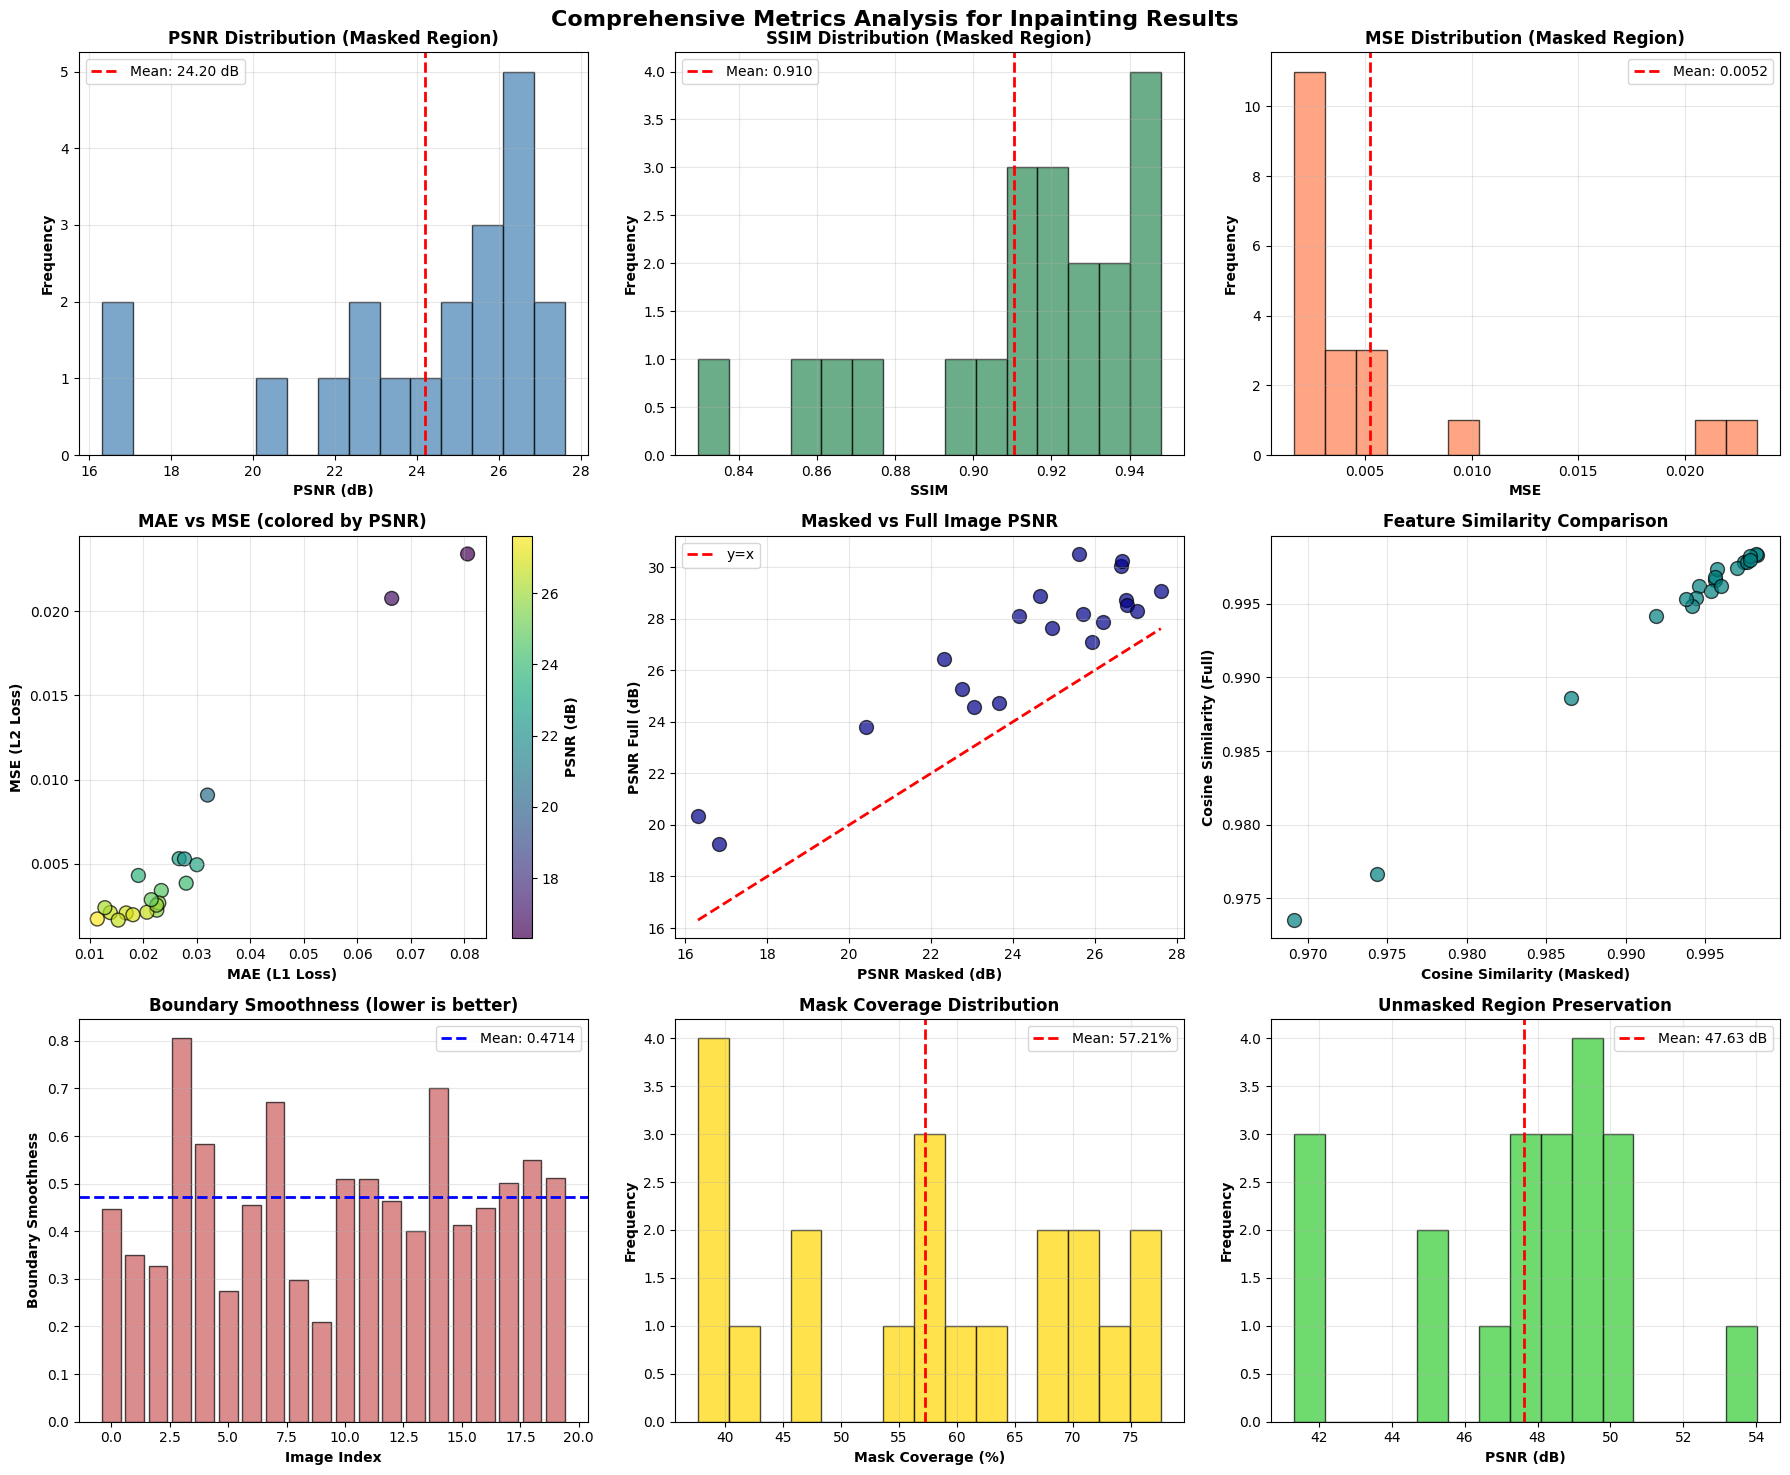

In [19]:
# Create comprehensive visualizations
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Comprehensive Metrics Analysis for Inpainting Results', fontsize=16, fontweight='bold')

# 1. PSNR Distribution (Masked)
ax = axes[0, 0]
ax.hist(df_metrics['PSNR_masked'], bins=15, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(df_metrics['PSNR_masked'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_metrics["PSNR_masked"].mean():.2f} dB')
ax.set_xlabel('PSNR (dB)', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('PSNR Distribution (Masked Region)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. SSIM Distribution (Masked)
ax = axes[0, 1]
ax.hist(df_metrics['SSIM_masked'], bins=15, color='seagreen', edgecolor='black', alpha=0.7)
ax.axvline(df_metrics['SSIM_masked'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_metrics["SSIM_masked"].mean():.3f}')
ax.set_xlabel('SSIM', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('SSIM Distribution (Masked Region)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. MSE Distribution (Masked)
ax = axes[0, 2]
ax.hist(df_metrics['MSE_masked'], bins=15, color='coral', edgecolor='black', alpha=0.7)
ax.axvline(df_metrics['MSE_masked'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_metrics["MSE_masked"].mean():.4f}')
ax.set_xlabel('MSE', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('MSE Distribution (Masked Region)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. MAE vs MSE (Masked)
ax = axes[1, 0]
ax.scatter(df_metrics['MAE_masked'], df_metrics['MSE_masked'], c=df_metrics['PSNR_masked'], 
           cmap='viridis', s=100, alpha=0.7, edgecolors='black')
ax.set_xlabel('MAE (L1 Loss)', fontweight='bold')
ax.set_ylabel('MSE (L2 Loss)', fontweight='bold')
ax.set_title('MAE vs MSE (colored by PSNR)', fontweight='bold')
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('PSNR (dB)', fontweight='bold')

# 5. Full vs Masked PSNR
ax = axes[1, 1]
ax.scatter(df_metrics['PSNR_masked'], df_metrics['PSNR_full'], s=100, alpha=0.7, 
           color='darkblue', edgecolors='black')
ax.plot([df_metrics['PSNR_masked'].min(), df_metrics['PSNR_masked'].max()],
        [df_metrics['PSNR_masked'].min(), df_metrics['PSNR_masked'].max()],
        'r--', linewidth=2, label='y=x')
ax.set_xlabel('PSNR Masked (dB)', fontweight='bold')
ax.set_ylabel('PSNR Full (dB)', fontweight='bold')
ax.set_title('Masked vs Full Image PSNR', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Cosine Similarity
ax = axes[1, 2]
ax.scatter(df_metrics['Cosine_Similarity_masked'], df_metrics['Cosine_Similarity_full'], 
           s=100, alpha=0.7, color='teal', edgecolors='black')
ax.set_xlabel('Cosine Similarity (Masked)', fontweight='bold')
ax.set_ylabel('Cosine Similarity (Full)', fontweight='bold')
ax.set_title('Feature Similarity Comparison', fontweight='bold')
ax.grid(True, alpha=0.3)

# 7. Boundary Smoothness
ax = axes[2, 0]
ax.bar(range(len(df_metrics)), df_metrics['Boundary_Smoothness'], color='indianred', alpha=0.7, edgecolor='black')
ax.axhline(df_metrics['Boundary_Smoothness'].mean(), color='blue', linestyle='--', linewidth=2, 
           label=f'Mean: {df_metrics["Boundary_Smoothness"].mean():.4f}')
ax.set_xlabel('Image Index', fontweight='bold')
ax.set_ylabel('Boundary Smoothness', fontweight='bold')
ax.set_title('Boundary Smoothness (lower is better)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 8. Mask Coverage
ax = axes[2, 1]
ax.hist(df_metrics['Mask_Percentage'], bins=15, color='gold', edgecolor='black', alpha=0.7)
ax.axvline(df_metrics['Mask_Percentage'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {df_metrics["Mask_Percentage"].mean():.2f}%')
ax.set_xlabel('Mask Coverage (%)', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Mask Coverage Distribution', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 9. Unmasked Region Preservation
ax = axes[2, 2]
ax.hist(df_metrics['PSNR_unmasked'], bins=15, color='limegreen', edgecolor='black', alpha=0.7)
ax.axvline(df_metrics['PSNR_unmasked'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {df_metrics["PSNR_unmasked"].mean():.2f} dB')
ax.set_xlabel('PSNR (dB)', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Unmasked Region Preservation', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comprehensive_metrics_visualization.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved to: comprehensive_metrics_visualization.png")
plt.show()

✅ Correlation heatmap saved to: metrics_correlation_heatmap.png


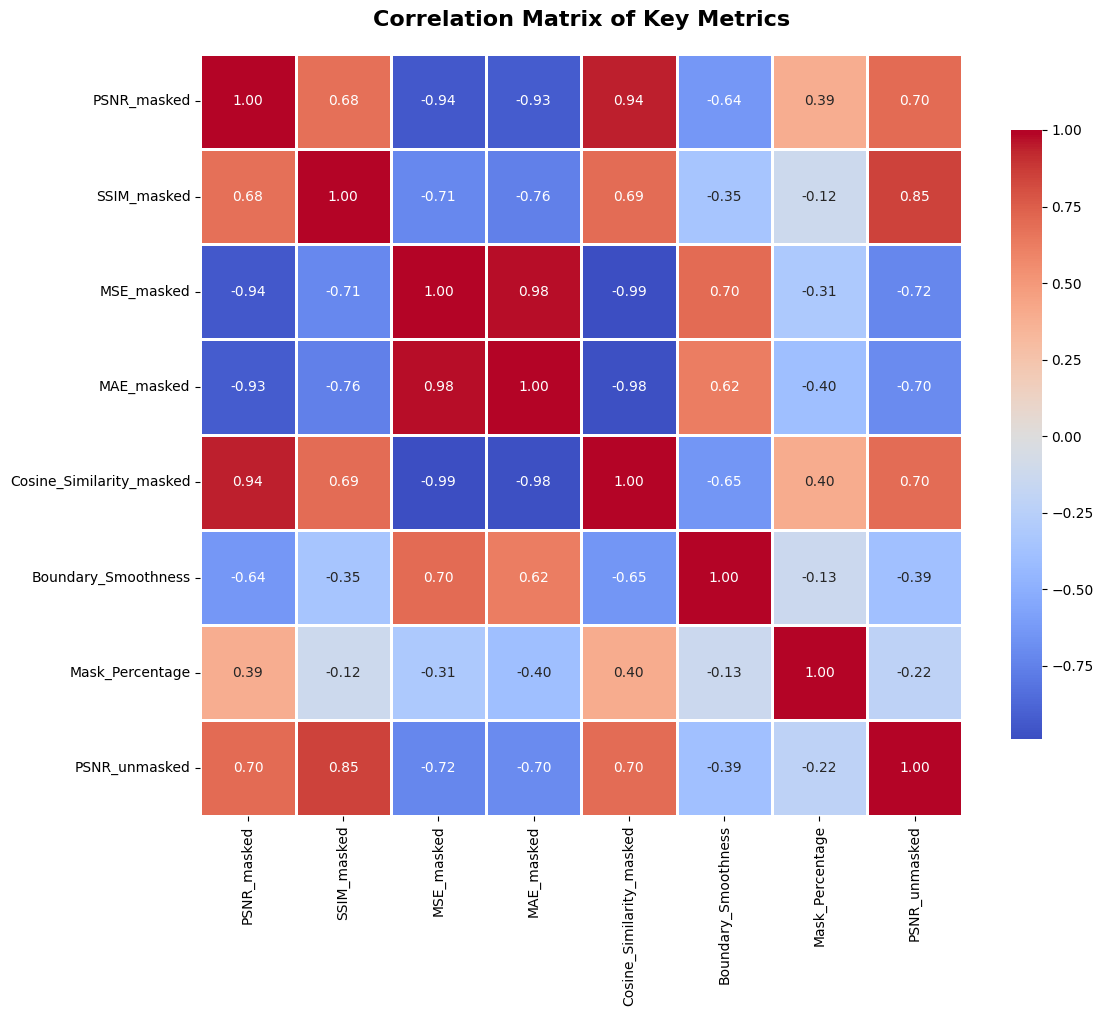

In [20]:
# Create correlation heatmap
plt.figure(figsize=(12, 10))

# Select key metrics for correlation analysis (NO LPIPS!)
key_metrics = [
    'PSNR_masked', 'SSIM_masked', 'MSE_masked', 'MAE_masked',
    'Cosine_Similarity_masked', 'Boundary_Smoothness',
    'Mask_Percentage', 'PSNR_unmasked'
]

correlation_matrix = df_metrics[key_metrics].corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})

plt.title('Correlation Matrix of Key Metrics', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('metrics_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("✅ Correlation heatmap saved to: metrics_correlation_heatmap.png")
plt.show()

In [21]:
# Generate Final Report Summary

print("\n" + "=" * 80)
print("📋 FINAL METRICS REPORT FOR PALETTE INPAINTING")
print("=" * 80)

report = f"""
DATASET: CelebA-HQ (256×256) - 20 Test Images
TASK: Face Inpainting using Palette Diffusion Model
CHECKPOINT: Step 200

{'='*80}
1. PIXEL-LEVEL METRICS (Masked Region)
{'='*80}
   PSNR:           {df_metrics['PSNR_masked'].mean():.4f} ± {df_metrics['PSNR_masked'].std():.4f} dB
                   Range: [{df_metrics['PSNR_masked'].min():.2f}, {df_metrics['PSNR_masked'].max():.2f}] dB
                   
   SSIM:           {df_metrics['SSIM_masked'].mean():.4f} ± {df_metrics['SSIM_masked'].std():.4f}
                   Range: [{df_metrics['SSIM_masked'].min():.4f}, {df_metrics['SSIM_masked'].max():.4f}]
                   
   MSE:            {df_metrics['MSE_masked'].mean():.6f} ± {df_metrics['MSE_masked'].std():.6f}
                   Range: [{df_metrics['MSE_masked'].min():.6f}, {df_metrics['MSE_masked'].max():.6f}]
                   
   MAE (L1):       {df_metrics['MAE_masked'].mean():.6f} ± {df_metrics['MAE_masked'].std():.6f}
                   Range: [{df_metrics['MAE_masked'].min():.6f}, {df_metrics['MAE_masked'].max():.6f}]

{'='*80}
2. FEATURE-BASED METRICS
{'='*80}
   Cosine Similarity (Masked):  {df_metrics['Cosine_Similarity_masked'].mean():.4f} ± {df_metrics['Cosine_Similarity_masked'].std():.4f}
   Cosine Similarity (Full):    {df_metrics['Cosine_Similarity_full'].mean():.4f} ± {df_metrics['Cosine_Similarity_full'].std():.4f}

{'='*80}
3. BOUNDARY & REGION QUALITY
{'='*80}
   Boundary Smoothness:         {df_metrics['Boundary_Smoothness'].mean():.4f} ± {df_metrics['Boundary_Smoothness'].std():.4f}
                                (Lower is better)
                                
   Unmasked PSNR:               {df_metrics['PSNR_unmasked'].mean():.4f} ± {df_metrics['PSNR_unmasked'].std():.4f} dB
                                (Should be very high - indicates preservation)

{'='*80}
4. MASK STATISTICS
{'='*80}
   Average Mask Coverage:       {df_metrics['Mask_Percentage'].mean():.2f}% ± {df_metrics['Mask_Percentage'].std():.2f}%
   Range:                       [{df_metrics['Mask_Percentage'].min():.2f}%, {df_metrics['Mask_Percentage'].max():.2f}%]

{'='*80}
5. INTERPRETATION & QUALITY ASSESSMENT
{'='*80}
"""

# Add quality verdict
psnr_mean = df_metrics['PSNR_masked'].mean()
ssim_mean = df_metrics['SSIM_masked'].mean()

report += f"\n   Overall Quality: "
if psnr_mean > 25 and ssim_mean > 0.85:
    report += "✅ EXCELLENT"
elif psnr_mean > 20 and ssim_mean > 0.75:
    report += "✅ GOOD"
elif psnr_mean > 15 and ssim_mean > 0.65:
    report += "⚠️  FAIR"
else:
    report += "❌ NEEDS IMPROVEMENT"

report += f"\n\n   PSNR Assessment:  "
if psnr_mean > 30:
    report += "Excellent (>30 dB)"
elif psnr_mean > 25:
    report += "Very Good (25-30 dB)"
elif psnr_mean > 20:
    report += "Good (20-25 dB)"
else:
    report += "Fair (<20 dB)"

report += f"\n   SSIM Assessment:  "
if ssim_mean > 0.9:
    report += "Excellent (>0.9)"
elif ssim_mean > 0.8:
    report += "Very Good (0.8-0.9)"
elif ssim_mean > 0.7:
    report += "Good (0.7-0.8)"
else:
    report += "Fair (<0.7)"

if 'fid_score' in dir() and fid_score is not None:
    report += f"\n\n{'='*80}\n6. FID SCORE (Distribution Quality)\n{'='*80}\n"
    report += f"   FID Score: {fid_score:.4f}\n"
    if fid_score < 10:
        report += "   Assessment: Excellent (<10)"
    elif fid_score < 30:
        report += "   Assessment: Very Good (10-30)"
    elif fid_score < 50:
        report += "   Assessment: Good (30-50)"
    else:
        report += "   Assessment: Fair (>50)"

if 'face_sim_results' in dir() and face_sim_results is not None:
    report += f"\n\n{'='*80}\n7. FACE IDENTITY PRESERVATION\n{'='*80}\n"
    report += f"   Face Similarity: {face_sim_results['mean']:.4f} ± {face_sim_results['std']:.4f}\n"
    report += f"   Success Rate: {face_sim_results['successful']}/{face_sim_results['total']}\n"
    if face_sim_results['mean'] > 0.8:
        report += "   Assessment: Excellent - Strong identity preservation"
    elif face_sim_results['mean'] > 0.7:
        report += "   Assessment: Very Good - Good identity preservation"
    elif face_sim_results['mean'] > 0.6:
        report += "   Assessment: Good - Moderate identity preservation"
    else:
        report += "   Assessment: Fair - Weak identity preservation"

report += f"\n\n{'='*80}\n"
report += f"✅ Report generated successfully\n"
report += f"📁 Files saved:\n"
report += f"   - inpainting_metrics_detailed.csv\n"
report += f"   - inpainting_metrics_summary.csv\n"
report += f"   - comprehensive_metrics_visualization.png\n"
report += f"   - metrics_correlation_heatmap.png\n"
report += f"{'='*80}\n"

print(report)

# Save report to file
with open("METRICS_REPORT.txt", "w") as f:
    f.write(report)

print("✅ Full report saved to: METRICS_REPORT.txt")


📋 FINAL METRICS REPORT FOR PALETTE INPAINTING

DATASET: CelebA-HQ (256×256) - 20 Test Images
TASK: Face Inpainting using Palette Diffusion Model
CHECKPOINT: Step 200

1. PIXEL-LEVEL METRICS (Masked Region)
   PSNR:           24.2001 ± 3.2048 dB
                   Range: [16.31, 27.61] dB
                   
   SSIM:           0.9105 ± 0.0323
                   Range: [0.8295, 0.9480]
                   
   MSE:            0.005243 ± 0.006037
                   Range: [0.001667, 0.023390]
                   
   MAE (L1):       0.026592 ± 0.017190
                   Range: [0.011368, 0.080644]

2. FEATURE-BASED METRICS
   Cosine Similarity (Masked):  0.9931 ± 0.0078
   Cosine Similarity (Full):    0.9942 ± 0.0069

3. BOUNDARY & REGION QUALITY
   Boundary Smoothness:         0.4714 ± 0.1472
                                (Lower is better)
                                
   Unmasked PSNR:               47.6269 ± 3.2426 dB
                                (Should be very high - indicates 

In [22]:
# Optional: Create a metrics comparison table for the report

print("\n" + "=" * 80)
print("📊 METRICS COMPARISON TABLE (For Report)")
print("=" * 80)

# Create a summary table (NO LPIPS!)
summary_table = pd.DataFrame({
    'Metric Category': [
        'Pixel-Level (Masked)',
        'Pixel-Level (Masked)',
        'Pixel-Level (Masked)',
        'Pixel-Level (Masked)',
        'Feature Similarity',
        'Boundary Quality',
        'Region Preservation',
    ],
    'Metric Name': [
        'PSNR',
        'SSIM',
        'MSE',
        'MAE (L1)',
        'Cosine Similarity',
        'Boundary Smoothness',
        'Unmasked PSNR',
    ],
    'Mean': [
        df_metrics['PSNR_masked'].mean(),
        df_metrics['SSIM_masked'].mean(),
        df_metrics['MSE_masked'].mean(),
        df_metrics['MAE_masked'].mean(),
        df_metrics['Cosine_Similarity_masked'].mean(),
        df_metrics['Boundary_Smoothness'].mean(),
        df_metrics['PSNR_unmasked'].mean(),
    ],
    'Std Dev': [
        df_metrics['PSNR_masked'].std(),
        df_metrics['SSIM_masked'].std(),
        df_metrics['MSE_masked'].std(),
        df_metrics['MAE_masked'].std(),
        df_metrics['Cosine_Similarity_masked'].std(),
        df_metrics['Boundary_Smoothness'].std(),
        df_metrics['PSNR_unmasked'].std(),
    ],
    'Min': [
        df_metrics['PSNR_masked'].min(),
        df_metrics['SSIM_masked'].min(),
        df_metrics['MSE_masked'].min(),
        df_metrics['MAE_masked'].min(),
        df_metrics['Cosine_Similarity_masked'].min(),
        df_metrics['Boundary_Smoothness'].min(),
        df_metrics['PSNR_unmasked'].min(),
    ],
    'Max': [
        df_metrics['PSNR_masked'].max(),
        df_metrics['SSIM_masked'].max(),
        df_metrics['MSE_masked'].max(),
        df_metrics['MAE_masked'].max(),
        df_metrics['Cosine_Similarity_masked'].max(),
        df_metrics['Boundary_Smoothness'].max(),
        df_metrics['PSNR_unmasked'].max(),
    ],
    'Better': [
        'Higher ↑',
        'Higher ↑',
        'Lower ↓',
        'Lower ↓',
        'Higher ↑',
        'Lower ↓',
        'Higher ↑',
    ],
    'Unit': [
        'dB',
        '0-1',
        '',
        '',
        '0-1',
        '',
        'dB',
    ]
})

# Add FID if available
if 'fid_score' in dir() and fid_score is not None:
    fid_row = pd.DataFrame({
        'Metric Category': ['Distribution Quality'],
        'Metric Name': ['FID Score'],
        'Mean': [fid_score],
        'Std Dev': [0],
        'Min': [fid_score],
        'Max': [fid_score],
        'Better': ['Lower ↓'],
        'Unit': ['']
    })
    summary_table = pd.concat([summary_table, fid_row], ignore_index=True)

# Add face similarity if available
if 'face_sim_results' in dir() and face_sim_results is not None:
    face_row = pd.DataFrame({
        'Metric Category': ['Face Identity'],
        'Metric Name': ['Face Similarity'],
        'Mean': [face_sim_results['mean']],
        'Std Dev': [face_sim_results['std']],
        'Min': [min(face_sim_results['all_scores'])],
        'Max': [max(face_sim_results['all_scores'])],
        'Better': ['Higher ↑'],
        'Unit': ['0-1']
    })
    summary_table = pd.concat([summary_table, face_row], ignore_index=True)

print(summary_table.to_string(index=False))

# Save to CSV
summary_table.to_csv('metrics_summary_table.csv', index=False)
print(f"\n✅ Summary table saved to: metrics_summary_table.csv")

# Also create a LaTeX version for academic reports
latex_table = summary_table.to_latex(index=False, float_format="%.4f")
with open('metrics_summary_table.tex', 'w') as f:
    f.write(latex_table)
print(f"✅ LaTeX table saved to: metrics_summary_table.tex")


📊 METRICS COMPARISON TABLE (For Report)
     Metric Category         Metric Name      Mean  Std Dev       Min       Max   Better Unit
Pixel-Level (Masked)                PSNR 24.200097 3.204753 16.309694 27.611075 Higher ↑   dB
Pixel-Level (Masked)                SSIM  0.910464 0.032324  0.829525  0.948016 Higher ↑  0-1
Pixel-Level (Masked)                 MSE  0.005243 0.006037  0.001667  0.023390  Lower ↓     
Pixel-Level (Masked)            MAE (L1)  0.026592 0.017190  0.011368  0.080644  Lower ↓     
  Feature Similarity   Cosine Similarity  0.993082 0.007822  0.969143  0.998255 Higher ↑  0-1
    Boundary Quality Boundary Smoothness  0.471445 0.147188  0.209586  0.805483  Lower ↓     
 Region Preservation       Unmasked PSNR 47.626942 3.242641 41.323011 54.014243 Higher ↑   dB

✅ Summary table saved to: metrics_summary_table.csv
✅ LaTeX table saved to: metrics_summary_table.tex
